This lab is based on the following https://github.com/adambielski/siamese-triplet/blob/master/Experiments_MNIST.ipynb

We will train on MNIST dataset using pairwise and triplet ranking losses. From the implementation point of view the trickiest thing is constructing the dataset loader. We will use the pre-constructed data loaders that we will download from the file below

In [1]:
!wget https://raw.githubusercontent.com/adambielski/siamese-triplet/master/datasets.py

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
from torchvision.datasets import MNIST
from torchvision import transforms

mean, std = 0.1307, 0.3081

train_dataset = MNIST('../data/MNIST', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = MNIST('../data/MNIST', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))
n_classes = 10

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST\MNIST\raw\train-images-idx3-ubyte.gz to ../data/MNIST\MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST\MNIST\raw\train-labels-idx1-ubyte.gz to ../data/MNIST\MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST\MNIST\raw\t10k-images-idx3-ubyte.gz to ../data/MNIST\MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data/MNIST\MNIST\raw

Processing...
Done!


c:\users\administrator\appdata\local\programs\python\python39\lib\site-packages\torchvision\datasets\mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
!ls

sample_data


Below is the dataloader you will use to train this, and an illustration of what it returns. Run this just to get an idea of what the dataloader is doing here. Essentially for a batch size of 32 it will return 32 triplets (indexed by j below)



torch.Size([1, 28, 28])
torch.Size([28, 28])


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


<Figure size 432x288 with 0 Axes>

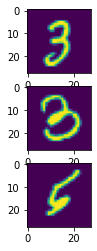

In [6]:
from datasets import TripletMNIST
import torch 

triplet_train_dataset = TripletMNIST(train_dataset)
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=32, shuffle=True)


(im1,im2,im3),_ = next(iter(triplet_train_loader))
#anchor, positive, negative
import matplotlib.pyplot as plt

plt.figure()
j=0
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(3,1) 
# use the created array to output your multiple images. In this case I have stacked 4 images vertically
print(im1[j].shape)
print(im1[j].squeeze().shape)
axarr[0].imshow(im1[j].squeeze()) 
axarr[1].imshow(im2[j].squeeze())
axarr[2].imshow(im3[j].squeeze())


Train the model using the triplet loss (https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginLoss.html). At each iteration load the 3 samples using the dataloader to act as anchor, positive, negative. Use 20 epochs for training and the adam optimizer with a suggested learning rate of 1e-3. You may experiment with margin parameters (suggest 0.05 to 0.5).

In [26]:
import torch.nn as nn
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.convnet = nn.Sequential(nn.Conv2d(1, 32, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(32, 64, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2))

        self.fc = nn.Sequential(nn.Linear(64 * 4 * 4, 256),
                                nn.PReLU(),
                                nn.Linear(256, 256),
                                nn.PReLU(),
                                nn.Linear(256, 4)
                                )

    def forward(self, x):
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def get_embedding(self, x):
        return self.forward(x)



In [27]:

model=EmbeddingNet()
(im1,im2,im3),_ = next(iter(triplet_train_loader))
print(im1.shape)
output1 = model(im1)
print(output1.shape)

torch.Size([100, 1, 28, 28])
torch.Size([100, 4])


In [28]:
#Use this model
#Use these dataloaders
from datasets import TripletMNIST
triplet_loss = nn.TripletMarginLoss(margin=0.2, p=2)
triplet_train_dataset = TripletMNIST(train_dataset)
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=100, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss=[] 
counter=[]
iteration_number = 0
for epoch in range(20):
    all_loss=[]
    for (im1,im2,im3),_  in triplet_train_loader:     
      optimizer.zero_grad()
      output1 = model(im1)
      output2 = model(im2)
      output3 = model(im3)
      loss = triplet_loss(output1,output2,output3)
      all_loss.append(loss.item())
      loss.backward()
      optimizer.step()
    print("Epoch {} Avg loss {}".format(epoch, sum(all_loss)/len(all_loss))) 


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Epoch 0 Avg loss 0.013994431830988106
Epoch 1 Avg loss 0.004463962324440823
Epoch 2 Avg loss 0.003418645114419784
Epoch 3 Avg loss 0.0028855749425239687
Epoch 4 Avg loss 0.002465450398946511


KeyboardInterrupt: ignored

Embedd the entire training set and perform classification on the 500 test set images using a nearest neighbor approach. Report the overall accuracy. Finally show the 5 nearest neighbor for 2 randomly selected samples.

In [29]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=500, shuffle=False)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=500, shuffle=True)
embs=[]
targets=[]
for img,label in train_loader:
    img_emb=model(img)
    for idx in range(len(img_emb)):
      embs.append(img_emb[idx].detach().numpy())  
      targets.append(label[idx])


  

In [30]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(embs,targets)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [32]:
 test_imgs,test_labels =next(iter(test_loader))
 test_embs=model(test_imgs)
 correct=0 
 for idx in range(len(test_labels)):
    nn_class=neigh.predict([test_embs[idx].detach().numpy()])
    org_class=test_labels[idx].item()
    # print(type(nn_class[0]))
    # print(type(org_class))
    if nn_class[0] == org_class:
      correct=correct+1

    # print(nn_class,test_labels[idx])
print("test classification accuracy=",correct/len(test_labels))

test classification accuracy= 0.988


In [50]:
from scipy.spatial import distance
import numpy as np
for idx in np.random.randint(500, size=3):
  p1=test_embs[idx].detach().numpy()
  for idx2 in range(len(embs)):
    dis=distance.euclidean(p1,embs[idx2])
    if dis<0.035:
        print("test point=",p1," label=",test_labels[idx].item(),
        "nearest train point=",embs[idx2]," label=",targets[idx2]," dist=",dis)
  print("\n")



test point= [ 1.1516725   1.0589375   0.24817315 -0.44755775]  label= 3 nearest train point= [ 1.1315659   1.0564456   0.23062131 -0.43402073]  label= tensor(3)  dist= 0.030030006542801857
test point= [ 1.1516725   1.0589375   0.24817315 -0.44755775]  label= 3 nearest train point= [ 1.1368015   1.0564634   0.23337558 -0.45503718]  label= tensor(3)  dist= 0.022409332916140556
test point= [ 1.1516725   1.0589375   0.24817315 -0.44755775]  label= 3 nearest train point= [ 1.134194    1.0798577   0.25700772 -0.46699774]  label= tensor(3)  dist= 0.034628208726644516
test point= [ 1.1516725   1.0589375   0.24817315 -0.44755775]  label= 3 nearest train point= [ 1.1238494   1.0602124   0.23511738 -0.46315226]  label= tensor(3)  dist= 0.03448755666613579
test point= [ 1.1516725   1.0589375   0.24817315 -0.44755775]  label= 3 nearest train point= [ 1.1334857   1.0476727   0.22428265 -0.4391755 ]  label= tensor(3)  dist= 0.033146247267723083
test point= [ 1.1516725   1.0589375   0.24817315 -0.4475